# Optimal Learning Rate 찾기 및 Huber Loss 함수 적용

손실 함수는 크게 분류 및 회귀 손실의 두 가지 유형으로 분류 할 수 있습니다. Huber Loss는 회귀 손실에 속합니다. Huber 손실은 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다. 

<img src="https://blog.kakaocdn.net/dn/081sh/btqNth1n6DL/rkSLdrV0RFuYg04k4VyeZK/img.png" width=300/>

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [2]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [4]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [5]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [6]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (16, 20)
y =  (16,)


## Stacked + Bidirectoinal LSTM

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
    return model

### Optimal Learning Rate 찾기

- epoch이 진행되면서 Learning Rate를 감소시킴  

- loss가 감소하다 증가하는 경우 learning rate를 시각화 하여 loss 증가 직전의 learning rate 선택  

- 선택한 learning rate 로 다시 train

In [8]:
model = create_model()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
27/27 [==============================] - 4s 28ms/step - loss: 103.9727 - mae: 104.4715 - lr: 1.0000e-08
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 101.1793 - mae: 101.6771 - lr: 1.1220e-08
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 100.1279 - mae: 100.6266 - lr: 1.2589e-08
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 99.2336 - mae: 99.7313 - lr: 1.4125e-08
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 98.2438 - mae: 98.7418 - lr: 1.5849e-08
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 97.1010 - mae: 97.5997 - lr: 1.7783e-08
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 95.8132 - mae: 96.3126 - lr: 1.9953e-08
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 94.3151 - mae: 94.8111 - lr: 2.2387e-08
Epoch 9/100
27/27 [==============================] - 0s 6ms/step - loss: 92.5589 - mae: 9

Epoch 73/100
27/27 [==============================] - 0s 6ms/step - loss: 35.1766 - mae: 35.6762 - lr: 3.9811e-05
Epoch 74/100
27/27 [==============================] - 0s 6ms/step - loss: 34.6024 - mae: 35.0994 - lr: 4.4668e-05
Epoch 75/100
27/27 [==============================] - 0s 6ms/step - loss: 41.4847 - mae: 41.9843 - lr: 5.0119e-05
Epoch 76/100
27/27 [==============================] - 0s 6ms/step - loss: 40.8140 - mae: 41.3096 - lr: 5.6234e-05
Epoch 77/100
27/27 [==============================] - 0s 6ms/step - loss: 39.3427 - mae: 39.8402 - lr: 6.3096e-05
Epoch 78/100
27/27 [==============================] - 0s 6ms/step - loss: 44.7157 - mae: 45.2126 - lr: 7.0795e-05
Epoch 79/100
27/27 [==============================] - 0s 6ms/step - loss: 57.1802 - mae: 57.6802 - lr: 7.9433e-05
Epoch 80/100
27/27 [==============================] - 0s 6ms/step - loss: 43.0074 - mae: 43.5069 - lr: 8.9125e-05
Epoch 81/100
27/27 [==============================] - 0s 6ms/step - loss: 40.9055 - mae:

- loss 시각화

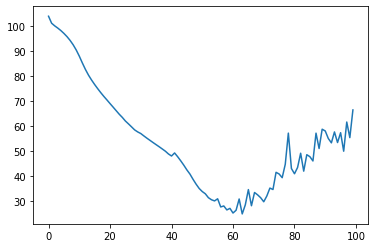

In [9]:
plt.plot(history.history['loss'])

### learning rate에 따른 loss 시각화

(1e-07, 0.0001, 20.0, 70.0)

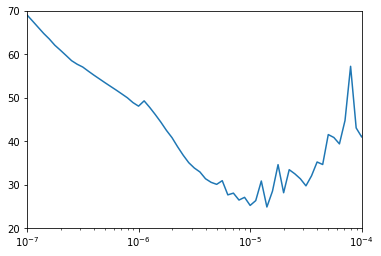

In [10]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 20, 70])

### model re-train

In [11]:
model = create_model()

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100)

Epoch 1/100
27/27 [==============================] - 3s 7ms/step - loss: 94.1335 - mae: 94.6326
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 59.6001 - mae: 60.0988
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 48.9563 - mae: 49.4521
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 41.1527 - mae: 41.6487
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 35.2855 - mae: 35.7832
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 31.1650 - mae: 31.6617
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 28.3390 - mae: 28.8330
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 27.6853 - mae: 28.1795
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 25.4350 - mae: 25.9317
Epoch 10/100
27/27 [==============================] - 0s 7ms/step - loss: 25.0088 - mae: 25.5020
Epoch 11/100
27/27 [===================

27/27 [==============================] - 0s 7ms/step - loss: 20.3389 - mae: 20.8298
Epoch 86/100
27/27 [==============================] - 0s 7ms/step - loss: 21.0810 - mae: 21.5687
Epoch 87/100
27/27 [==============================] - 0s 7ms/step - loss: 19.9313 - mae: 20.4238
Epoch 88/100
27/27 [==============================] - 0s 7ms/step - loss: 21.5982 - mae: 22.0921
Epoch 89/100
27/27 [==============================] - 0s 7ms/step - loss: 20.9707 - mae: 21.4606
Epoch 90/100
27/27 [==============================] - 0s 7ms/step - loss: 20.9167 - mae: 21.4108
Epoch 91/100
27/27 [==============================] - 0s 7ms/step - loss: 20.5396 - mae: 21.0300
Epoch 92/100
27/27 [==============================] - 0s 7ms/step - loss: 23.5704 - mae: 24.0643
Epoch 93/100
27/27 [==============================] - 0s 7ms/step - loss: 20.7873 - mae: 21.2820
Epoch 94/100
27/27 [==============================] - 0s 7ms/step - loss: 20.3364 - mae: 20.8263
Epoch 95/100
27/27 [=======================

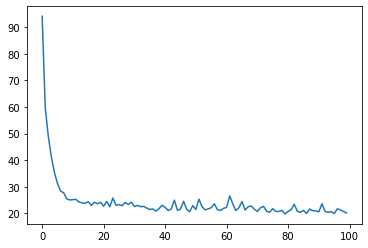

In [12]:
plt.plot(history.history['loss'])

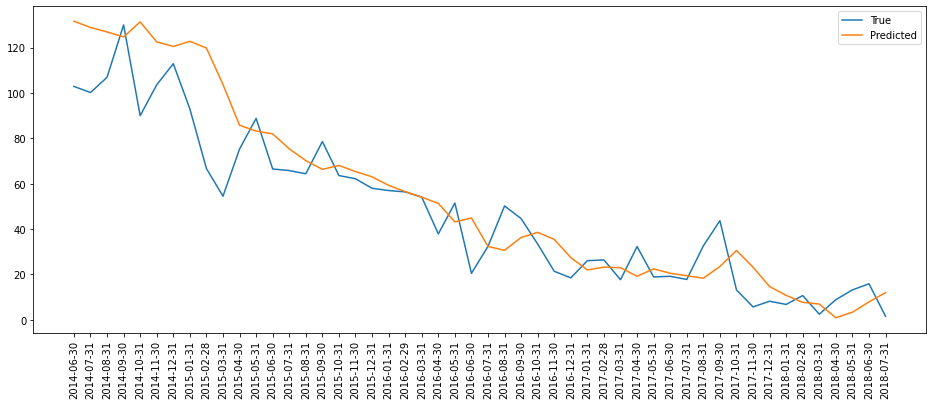

In [13]:
forecast = []

for time in range(len(time_series) - window_size):
    prediction = model.predict(time_series[time:time+window_size].reshape(1, -1))
    forecast.append(prediction[0][0])
    
result = forecast[split_time-window_size:]

plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test, result, label='Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [14]:
print(tf.keras.metrics.mean_squared_error(X_test, result).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, result).numpy())

290.64304
12.295989
